# BART-Large XSum

In [1]:
!pip install transformers datasets evaluate nltk
import nltk
nltk.download('punkt')

from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
import evaluate
import torch
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
from zipfile import ZipFile

# Check if CUDA is available and set the device to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using device: cuda


In [3]:

# Load the model and tokenizer
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-xsum').to(device)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-xsum')

# Load your dataset
dataset = load_dataset('csv', data_files={
    'train': '/kaggle/input/input-dataset-2/train.csv',
    'validation': '/kaggle/input/input-dataset-2/validation.csv',
    'test': '/kaggle/input/input-dataset-2/test.csv'
})


In [4]:

# Function to preprocess the dataset
def preprocess_function(examples):
    texts = [str(text) for text in examples["Text"]]
    summaries = [str(summary) for summary in examples["Summary"]]
    model_inputs = tokenizer(texts, max_length=512, truncation=True, padding="max_length", return_tensors="pt")
    labels = tokenizer(summaries, max_length=128, truncation=True, padding="max_length", return_tensors="pt")
    model_inputs["labels"] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in label_example] for label_example in labels["input_ids"]
    ]
    return model_inputs

# Apply the preprocessing function to the dataset
dataset = dataset.map(preprocess_function, batched=True, remove_columns=["Text", "Summary"])

# Prepare training arguments
training_args = TrainingArguments(
    output_dir='/kaggle/working/report-generator',
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    save_strategy='epoch',
    report_to="none",
    load_best_model_at_end=True
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer
)

# Train the model
trainer.train()
trainer.save_model()



Map:   0%|          | 0/2507 [00:00<?, ? examples/s]

Map:   0%|          | 0/716 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/3444854194.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.636400,1.467565
2,1.104400,1.447941
3,0.765400,1.565039


/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


In [8]:
!pip install rouge_score

  Using cached rouge_score-0.1.2.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=7aa43c2b7b7d99cedfd2bc2b2cd7d9bbef1e27a07412ce7a0dd33ccbfc68fbfd
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import pandas as pd

# Load the original validation data
validation_data = pd.read_csv('/kaggle/input/input-dataset-2/validation.csv')

# Evaluate using the loaded text data
rouge = evaluate.load('rouge')
predictions = []
references = []

for index, row in validation_data.iterrows():
    text = row['Text']
    summary = row['Summary']

    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the device

    with torch.no_grad():
        outputs = model.generate(inputs['input_ids'])

    decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    predictions.append(decoded_preds[0])
    references.append(summary)

results = rouge.compute(predictions=predictions, references=references)
print(results)


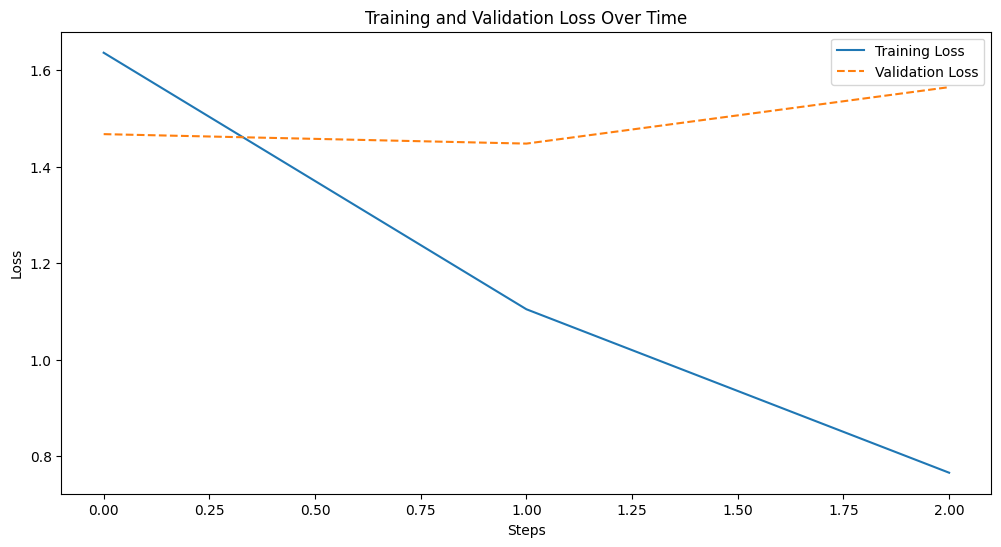

In [12]:
import matplotlib.pyplot as plt

# Initialize lists to store loss values
train_losses = []
validation_losses = []

# Extract training and validation loss from log_history
for entry in trainer.state.log_history:
    if 'loss' in entry:  # This checks for training loss logged during training steps
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:  # This checks for validation loss logged at each evaluation step
        validation_losses.append(entry['eval_loss'])

# Plotting the losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


In [ ]:
test_set = dataset['test'].map(lambda x: preprocess_function(x, remove_columns=False), batched=True, remove_columns=["Summary"])


In [ ]:
def generate_summary(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move input tensors to the GPU
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Generate summaries for the test set
test_reviews = test_set['Text']
summaries = [generate_summary(review) for review in test_reviews]
final_report = " ".join(summaries)
print(final_report)

In [ ]:
# Zip the model directory
!zip -r /kaggle/working/my_model.zip /kaggle/working/report-generator